In [1]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from utils import train_lda_model, load_bow

# gensim
from gensim.models import TfidfModel, LdaModel, LdaMulticore, CoherenceModel, ldamodel
from gensim.corpora import Dictionary


In [2]:
# Load corpus
corpus_name = '25_venues'
texts = load_bow(corpus_name)
id2word = Dictionary(texts)
corpus = [id2word.doc2bow(text) for text in tqdm(texts)]


100%|██████████| 164756/164756 [00:10<00:00, 15876.76it/s]


In [5]:
# HYPERPARAMTETERS FOR LDA

# df-filter: low_value, search space: 
df_range = [0.5, 1]

# tfidf-filter low_value, search space:
tfidf_range = [0.0075, 0.015]

# number-of-topics: K, search space:
K_range = list(range(35,65,5))


# alpha: alpha, search space:
alpha_range = ['auto']

# eta: eta, search space:
eta_range = ['symmetric', 'auto']

# Parametric Space:
search_space = list(product(df_range, tfidf_range, K_range, alpha_range, eta_range))
search_space = pd.DataFrame(search_space, columns=['df', 'tfidf', 'K', 'alpha', 'eta'])
search_space['coherence'] = np.nan
#search_space.to_csv(f'./models/lda_models_results.csv', index=False)
len(search_space)


48

In [4]:
models_results = pd.read_csv('models/lda_models_results.csv')
search_space = models_results[models_results.isna().any(axis=1)]

search_space[['df', 'tfidf']] = search_space[['df', 'tfidf']].astype(float)
search_space[['alpha', 'eta']] = search_space[['alpha', 'eta']].astype(str)
search_space['K'] = search_space['K'].astype(int)
search_space = search_space[search_space.isna().any(axis=1)]

unique_df_tfidf = search_space[['df', 'tfidf']].drop_duplicates().values
unique_K_alpha_eta = search_space[['K', 'alpha', 'eta']].drop_duplicates().values


for df, tfidf in unique_df_tfidf:
    print(f'Filtering with df={df} and tfidf={tfidf}')
    clean_id2word = Dictionary(texts)
    clean_id2word.filter_extremes(no_above=df)
    tfidf_model = TfidfModel(corpus, id2word=clean_id2word)
    vocab_tfidf = list(chain.from_iterable(tfidf_model[corpus]))
    clean_id2word.filter_tokens(bad_ids=[tokenid for tokenid, tfidf_value in vocab_tfidf if tfidf_value < tfidf])
    clean_corpus = [clean_id2word.doc2bow(text) for text in texts]

    models = []
    for K, alpha, eta in tqdm(unique_K_alpha_eta):
        models.append(train_lda_model(clean_corpus, clean_id2word, K, alpha, eta, df, tfidf))

    cm = CoherenceModel.for_models(models, clean_id2word, texts=texts, coherence='c_v')
    coherences = cm.compare_models(models)
    for (K, alpha, eta), (_, avg_coherence) in zip(unique_K_alpha_eta, coherences):
        condition = (models_results['df']==df) \
             & (models_results['tfidf']==tfidf) \
             & (models_results['K']==K) \
             & (models_results['alpha']==alpha) \
             & (models_results['eta']==eta)
        models_results.loc[condition, 'coherence'] = avg_coherence
        models_results.to_csv('models/lda_models_results.csv', index=False)

C:\Users\vitor\AppData\Local\Temp\ipykernel_3500\3738967738.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  search_space[['df', 'tfidf']] = search_space[['df', 'tfidf']].astype(float)
C:\Users\vitor\AppData\Local\Temp\ipykernel_3500\3738967738.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  search_space[['alpha', 'eta']] = search_space[['alpha', 'eta']].astype(str)
C:\Users\vitor\AppData\Local\Temp\ipykernel_3500\3738967738.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

Filtering with df=1.0 and tfidf=0.015


100%|██████████| 24/24 [6:35:26<00:00, 988.59s/it]  


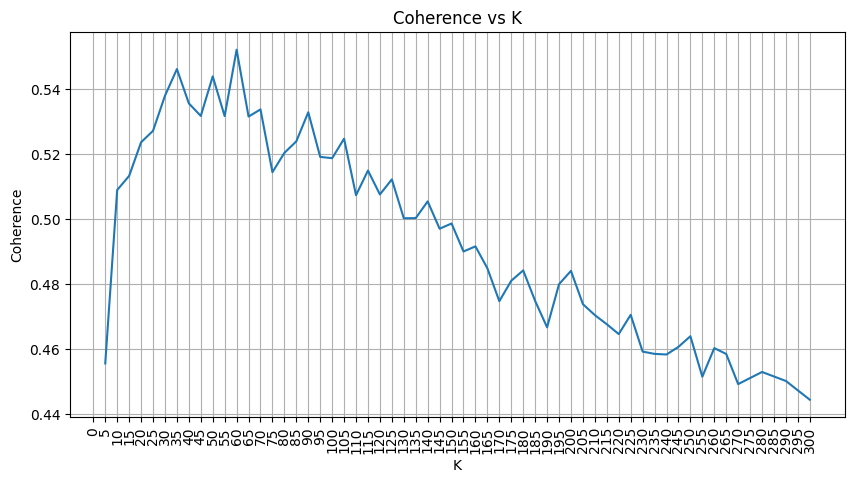

In [8]:
# PLOT RESULTS FOR K SEARCH SPACE
import os

# join all the .csv files inside the folder 'models' and join them, if a row is repeated, the coherence is the maximum
models_results = pd.concat([pd.read_csv(f'models/{file}') for file in os.listdir('models') if file.endswith('.csv') and file.startswith('lda_models_results- K')])
models_results = models_results.groupby(['df', 'tfidf', 'K', 'alpha', 'eta']).max().reset_index()
models_results.to_csv('models/lda_models_results- Ksearch_results.csv', index=False)

# line 'o-' plot the column 'coherence' versus 'K' in the csv file 'models/lda_models_results.csv' 
models_results = pd.read_csv('models/lda_models_results- Ksearch_results.csv')

plt.figure(figsize=(10, 5))
plt.plot(models_results['K'], models_results['coherence'], '-')
xticks = np.arange(0, 305, 5)
plt.xticks(xticks, rotation=90)
plt.xlabel('K')
plt.ylabel('Coherence')
plt.title('Coherence vs K')

plt.grid(True)
